Imports

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

[[1,2,3,4,5,6,7], [1,2,3,4,5,6,7]]

In [124]:
ds = pd.read_csv('falls_vs_normal.csv')
ds

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


In [125]:

def split_observations(ds, window_size):
  ds_arr = ds.to_numpy()
  observations = []
  y_values = []

  for i in range(0, len(ds_arr), window_size):
    observation = ds_arr[i:i + window_size, :-1]  # Slice a window, exclude last col
    observations.append(observation)

    # Append y value every window_size (i.e., every 400 values)
    if i % 400 == 0:  # Check for divisibility by 400, not remainder
      y_value = ds_arr[i, -1]
      # Convert string to 1 if it contains "fall", otherwise 0
      y_value = 1 if "fall" in y_value else 0
      y_values.append(y_value)
      #y_values.append(ds_arr[i, -1])  # Append only the last value of the window

  return np.array(observations), np.array(y_values)
        

In [126]:
WINDOW_SIZE = 400
x, y = split_observations(ds, WINDOW_SIZE)
x.shape, y.shape

((242, 400, 6), (242,))

In [127]:
X_train, y_train = x[:200], y[:200]
X_val, y_val = x[200:220], y[200:220]
X_test, y_test = x[220:], y[220:]
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
print(y_train)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [128]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains string labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)
y_train.shape, y_val.shape, y_test.shape

((200,), (20,), (22,))

In [129]:
# Reshape y_train (and similarly y_val, y_test) for multi-class classification
#y_train = y_train.reshape(y_train.shape[0], 1)
#y_val = y_val.reshape(y_val.shape[0], 1)
#y_test = y_test.reshape(y_test.shape[0], 1)
#y_train.shape, y_val.shape, y_test.shape

In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [150]:
model1 = Sequential()
model1.add(InputLayer((400,6)))
model1.add(LSTM(128))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,281 (286.25 KB)

 Trainable params: 73,281 (286.25 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
cp = ModelCheckpoint('model1/model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['Accuracy', 'Precision', 'Recall'])

In [152]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - Accuracy: 0.7711 - Precision: 0.6849 - Recall: 0.2619 - loss: 0.2064 - val_Accuracy: 0.8000 - val_Precision: 1.0000 - val_Recall: 0.5556 - val_loss: 0.1855
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - Accuracy: 0.8786 - Precision: 0.9311 - Recall: 0.5327 - loss: 0.1126 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0829
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - Accuracy: 0.9288 - Precision: 0.9172 - Recall: 0.7867 - loss: 0.0676 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0560
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - Accuracy: 0.9521 - Precision: 0.9770 - Recall: 0.8323 - loss: 0.0572 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_loss: 0.0566
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - Accuracy: 0.9733 - Precision: 1.0000 - Recall: 0.8898 - loss: 0.0425 - val_Accuracy: 1.0000 - val_Precision: 1.0000 

In [153]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/model.keras')

In [154]:
print(len(X_val))
val_predictions = model1.predict(X_val).flatten()
print(val_predictions)
print(len(val_predictions))
print(len(y_val))
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actual':y_val})
val_results

20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[ 0.19355744 -0.43495068 -0.06052491  0.897048    0.9779678   0.8556221
  0.8539018   0.93159     0.8569732   1.0031109   0.00696179 -0.42830503
  0.17151424 -0.10463645 -0.15304992  0.40770343  0.07035737  0.19929186
  1.1191738   0.9935439 ]
20
20


,Val Predictions,Actual
0,0.193557,0
1,-0.434951,0
2,-0.060525,0
3,0.897048,1
4,0.977968,1
5,0.855622,1
6,0.853902,1
7,0.931590,1
8,0.856973,1
9,1.003111,1


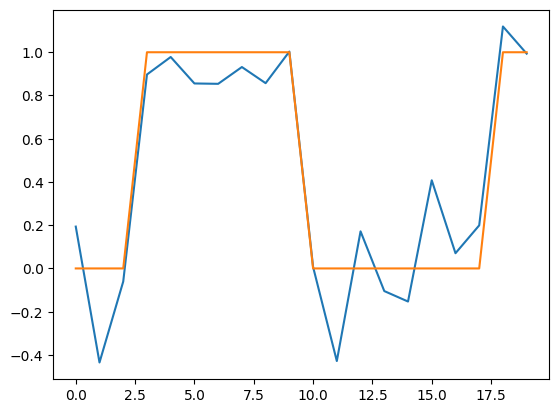

In [155]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][:200])
plt.plot(val_results['Actual'][:200])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


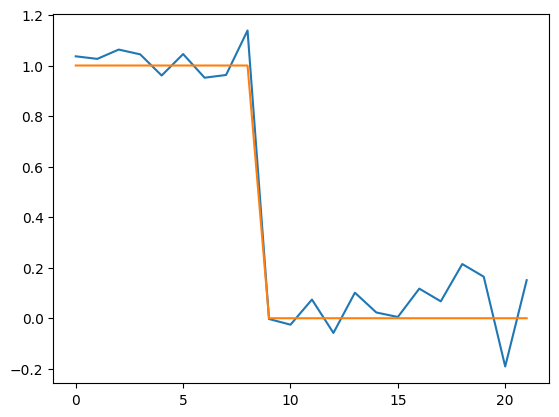

In [156]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actual':y_test})
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actual'])